## Import Libraries

In [89]:
# !pip install nltk==3.5
# !pip install numpy matplotlib

In [90]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data & Processing

In [91]:
# 0 : Negative, 1 : Positive

# Load Data
train_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/train.tsv', sep = "\t")
test_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/dev.tsv', sep = "\t")

In [92]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_sentence(sentence):
    translator = str.maketrans('', '', string.punctuation)
    sentence = sentence.translate(translator)

    sentence = sentence.lower()

    tokens = word_tokenize(sentence)

    tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return lemmatized_tokens

train_df['Tokenized_Sentence'] = train_df['sentence'].apply(preprocess_sentence)
test_df['Tokenized_Sentence'] = test_df['sentence'].apply(preprocess_sentence)

In [93]:
train_X = train_df['Tokenized_Sentence'].values
train_y = train_df['label'].values

test_X = test_df['Tokenized_Sentence'].values
test_y = test_df['label'].values

train_X

array([list(['hide', 'new', 'secretion', 'parental', 'unit']),
       list(['contains', 'wit', 'labored', 'gag']),
       list(['love', 'character', 'communicates', 'something', 'rather', 'beautiful', 'human', 'nature']),
       ..., list(['achieving', 'modest', 'crowdpleasing', 'goal', 'set']),
       list(['patient', 'viewer']),
       list(['new', 'jangle', 'noise', 'mayhem', 'stupidity', 'must', 'serious', 'contender', 'title'])],
      dtype=object)

In [94]:
# pair data 개수 확인하기
print("Length train_X : {}" .format(len(train_X)))
print("Length test_y : {}\n" .format(len(train_y)))

print("Length test_X : {}" .format(len(test_X)))
print("Length test_y : {}" .format(len(test_y)))

Length train_X : 67349
Length test_y : 67349

Length test_X : 872
Length test_y : 872


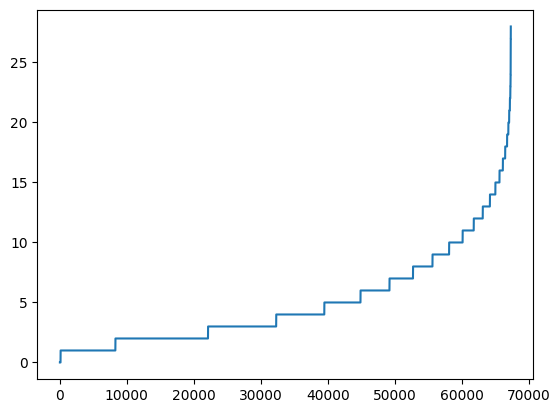

In [95]:
# network에 입력하려면, data의 크기(문장의 길이)는 동일해야함 -> padding
# 최대 단어 길이 : 28 -> 28을 기준으로 모든 vector를 28로 길이를 맞춰준다.
train_X_len = [len(x) for x in train_X]
train_X_len = sorted(train_X_len)

test_X_len = [len(x) for x in test_X]
test_X_len = sorted(test_X_len)

plt.plot(train_X_len)
plt.show()

In [96]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_X = tokenizer.texts_to_sequences(train_X)
train_X = pad_sequences(train_X, maxlen = 28, padding = 'post')

test_X = tokenizer.texts_to_sequences(test_X)
test_X = pad_sequences(test_X, maxlen = 28, padding = 'post')

In [97]:
# 확인
train_X[:10]

array([[ 4112,    26, 11315,  6664,  4733,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [ 2688,   227,  1819,   413,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   21,     6,  5520,    29,   104,   169,    93,   523,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  489,   568,  5521,  1820,   583,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  161,  4734,   447,   102,    48,  4378,     0,     0,     0,
            0

## Modeling Layers & Train

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length = 28),
    tf.keras.layers.LSTM(units = 128),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 28, 300)           6000000   
                                                                 
 lstm_10 (LSTM)              (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 2)                 258       
                                                                 
Total params: 6219906 (23.73 MB)
Trainable params: 6219906 (23.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
train_X.shape, train_y.shape

((67349, 28), (67349,))

In [100]:
es = EarlyStopping(patience = 3)

history = model.fit(train_X, train_y,
                    epochs = 20,
                    batch_size = 128,
                    validation_split = 0.2,
                    callbacks = [es],
                    )

Epoch 1/20
421/421 [==============================] - 79s 44ms/step - loss: 0.4314 - accuracy: 0.7870 - val_loss: 0.2904 - val_accuracy: 0.8853
Epoch 2/20
421/421 [==============================] - 7s 16ms/step - loss: 0.2333 - accuracy: 0.9127 - val_loss: 0.2810 - val_accuracy: 0.8961
Epoch 3/20
421/421 [==============================] - 5s 11ms/step - loss: 0.1782 - accuracy: 0.9322 - val_loss: 0.2782 - val_accuracy: 0.9014
Epoch 4/20
421/421 [==============================] - 3s 8ms/step - loss: 0.1428 - accuracy: 0.9434 - val_loss: 0.2848 - val_accuracy: 0.8998
Epoch 5/20
421/421 [==============================] - 5s 12ms/step - loss: 0.1170 - accuracy: 0.9534 - val_loss: 0.3180 - val_accuracy: 0.9064
Epoch 6/20
421/421 [==============================] - 5s 11ms/step - loss: 0.0992 - accuracy: 0.9596 - val_loss: 0.3161 - val_accuracy: 0.9064


## Plotting

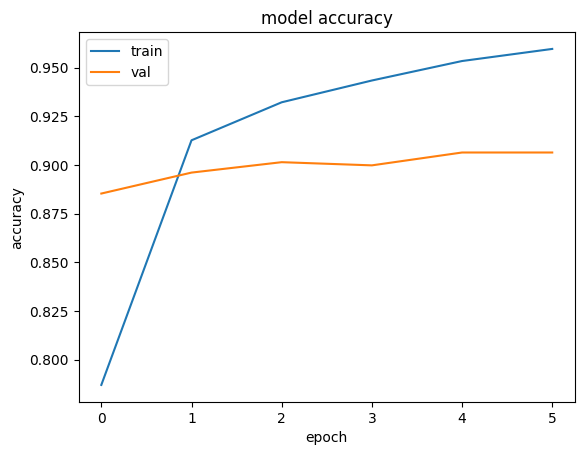

In [110]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('acc.png')
plt.show()

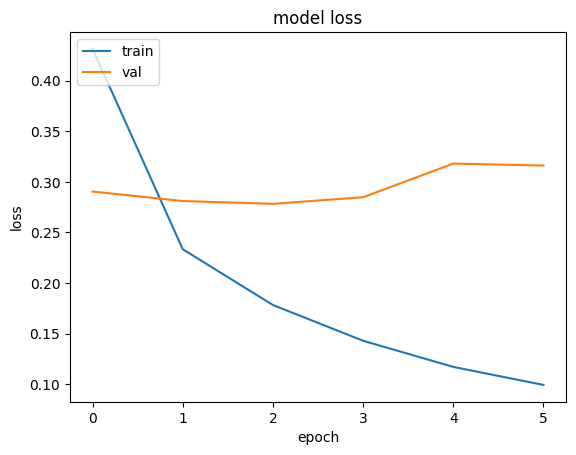

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [108]:
loss, accuracy = model.evaluate(test_X, test_y,
                                verbose = False)

print('Loss : {}'.format(loss))
print('Accuracy : {}'.format(accuracy))

Loss : 0.7088553309440613
Accuracy : 0.7981651425361633


In [109]:
y_pred_probs = model.predict(test_X)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(test_y, y_pred))

28/28 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       428
           1       0.79      0.83      0.81       444

    accuracy                           0.80       872
   macro avg       0.80      0.80      0.80       872
weighted avg       0.80      0.80      0.80       872

